In [0]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from theano.tensor.nnet import conv2d, relu, softmax
from theano.tensor.signal import pool
from sklearn.utils import shuffle

def error_rate(y, t):
    return np.mean(y != t)

def convpool(X, W, b, poolsize=(2, 2)):
    conv_out = conv2d(input=X, filters=W)
    pool_out = pool.pool_2d(input=conv_out, ws=poolsize, ignore_border=True)
    return relu(pool_out + b.dimshuffle('x', 0, 'x', 'x'))

def init_weights(shape, poolsize):
    W = np.random.randn(*shape) * np.sqrt(2/np.prod(shape[1:]))
    return W.astype(np.float32)

In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.reshape(60000, 1, 28, 28)/255).astype(np.float32)
X_test = (X_test.reshape(10000, 1, 28, 28)/255).astype(np.float32)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


Epoch:  1  Step:  10 / 484  Cost:  1.7249504  Error %:  0.4136
Epoch:  1  Step:  20 / 484  Cost:  1.756068  Error %:  0.5197
Epoch:  1  Step:  30 / 484  Cost:  1.8294035  Error %:  0.6201
Epoch:  1  Step:  40 / 484  Cost:  1.2705159  Error %:  0.3559
Epoch:  1  Step:  50 / 484  Cost:  0.64716816  Error %:  0.227
Epoch:  1  Step:  60 / 484  Cost:  1.8214833  Error %:  0.2606
Epoch:  1  Step:  70 / 484  Cost:  0.8641532  Error %:  0.292
Epoch:  1  Step:  80 / 484  Cost:  0.657473  Error %:  0.1932
Epoch:  1  Step:  90 / 484  Cost:  0.7683007  Error %:  0.2184
Epoch:  1  Step:  100 / 484  Cost:  1.0573548  Error %:  0.1882
Epoch:  1  Step:  110 / 484  Cost:  0.44335082  Error %:  0.1289
Epoch:  1  Step:  120 / 484  Cost:  0.64225703  Error %:  0.2193
Epoch:  2  Step:  10 / 484  Cost:  0.4389738  Error %:  0.1465
Epoch:  2  Step:  20 / 484  Cost:  0.38385913  Error %:  0.1098
Epoch:  2  Step:  30 / 484  Cost:  0.32074416  Error %:  0.0881
Epoch:  2  Step:  40 / 484  Cost:  0.41648746  Erro

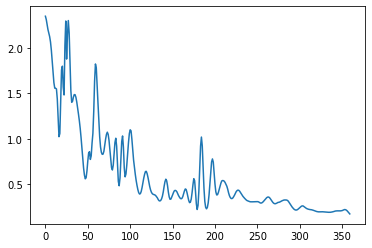

In [7]:
epochs = 3
lr = np.float32(1e-2)
mu = np.float32(1 - 1e-2)

batch_sz = 500
n_batches = X_train.shape[0]//batch_sz

M = 400
K = 10
poolsize = (2, 2)

#Convpool layers
W1_init = init_weights((32, 1, 5, 5), poolsize)
b1_init = np.zeros(32, dtype=np.float32)
W2_init = init_weights((64, 32, 5, 5), poolsize)
b2_init = np.zeros(64, dtype=np.float32)

#ANN layers
W3_init = (np.random.randn(64*4*4, M) / np.sqrt(64*4*4 + M)).astype(np.float32)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = (np.random.randn(M, K) / np.sqrt(M + K)).astype(np.float32)
b4_init = np.zeros(K, dtype=np.float32)

X = T.tensor4('X', dtype='float32')
Y = T.ivector('y')

W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init, 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init, 'W4')
b4 = theano.shared(b4_init, 'b4')

Z1 = convpool(X, W1, b1, poolsize)
Z2 = convpool(Z1, W2, b2, poolsize)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = softmax(Z3.dot(W4) + b4)

cost = -(T.log(pY[T.arange(Y.shape[0]), Y])).mean()
pred = T.argmax(pY, axis=1)

params = [W1, b1, W2, b2, W3, b3, W4, b4]
dparams = [theano.shared(np.zeros_like(p.get_value(), dtype=np.float32)) for p in params]

grads = T.grad(cost, params)
updates = [(dp, mu*dp - lr*g) for dp, g in zip (dparams, grads)] + [(p, p+dp) for p, dp in zip(params, dparams)]

train = theano.function(
    inputs=[X, Y],
    updates=updates
)

prediction = theano.function(
    inputs=[X, Y],
    outputs=[cost, pred]
)

costs = []
for i in range(epochs):
    for j in range(n_batches):
        X_batch = X_train[j*batch_sz:(j*batch_sz + batch_sz)]
        y_batch = y_train[j*batch_sz:(j*batch_sz + batch_sz)]

        train(X_batch, y_batch)
        cost_val, pred_val = prediction(X_test, y_test)
        costs.append(cost_val)
        if (i+1)*(j+1) % 10 == 0:
            print('Epoch: ', i+1, ' Step: ', (i+1)*(j+1), '/', (epochs+1)*(n_batches+1), ' Cost: ', cost_val, ' Error %: ', error_rate(pred_val, y_test))

plt.plot(costs)
plt.show()